In [ ]:
# Group 12
    # Sanjib Paudel
    # Premsai Ganesh Charugundla
    # Sarath Durisala
    # Rasagna Vadde
# CSCE 5290.003
# Group Project
# Dr. Zeenat Tariq
# November 28, 2022

# Text Classification

In [1]:
# import all necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import nltk
import keras
import spacy
import numpy as np
import tensorflow as tf

from pandas import DataFrame
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from textblob import TextBlob

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from youtube_transcript_api import YouTubeTranscriptApi
import urllib.request

from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest

2022-11-27 02:45:07.060402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import IMDB datasets
# https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
df = pd.read_csv("dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Before preprocessing
raw_corpus = []
for i in range(0, len(df['review'])):
    review = df['review'][i].split() # tokenization
    review = ' '.join(review)
    raw_corpus.append(review)
print(raw_corpus[:1])

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [74]:
# Create methods to preprocess(clean documents, stemming and Lemmatization)
nltk.download('stopwords')
def clean_doc(doc):
    doc = re.sub(r'<[^/>][^>]*>', '', doc) # removing HTML tag
    doc = re.sub(r'""', '"', doc) # removing one double quote
    doc = re.sub(r'\n', ' ', doc) # removing next line 
    doc = re.sub(r"[^a-zA-Z.!?]", ' ', doc) # removing puntuation
    doc = re.sub('[.]{2,}', ' ', doc) # Remove multiple dots
    doc = doc.lower() # lowercase document
    doc = " ".join(doc.split()) # Remove extra spaces
    return doc    

def normalize_tokens(tokens):
    ps = PorterStemmer() 
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for word in tokens:
        ps_word = ps.stem(word)
        lemma_word = lemmatizer.lemmatize(ps_word)
        clean_tokens.append(lemma_word)
    return clean_tokens

def remove_stopwords(tokens):
    return [word for word in tokens if not word in stopwords.words()]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanjib.paudel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Clean documents with regular expression
corpus = []
for i in range(0, len(df['review'])):
    corpus.append(clean_doc(df['review'][i]))
print(corpus[:1])

['one of the other reviewers has mentioned that after watching just oz episode you ll be hooked. they are right as this is exactly what happened with me.the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go. trust me this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs sex or violence. its is hardcore in the classic use of the word.it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda. em city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away.i would say the main appeal of the show is due to the fact that it goes where other shows wouldn t dare. forget 

In [6]:
# Tokenization
tokenized_words=[word_tokenize(sentence) for sentence in corpus]
print(tokenized_words[:1])

[['one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', 'll', 'be', 'hooked', '.', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'me.the', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'unflinching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', '.', 'trust', 'me', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'timid', '.', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', '.', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word.it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'penitentary', '.', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an', 'experimental', 'section', 'of', 'the', 'prison', 'where', 'all'

In [7]:
# Stemming and Lemmatization
clean_corpus = []
progress_bar_percent = -1
for idx, tok_sent in enumerate(tokenized_words):
    clean_corpus.append(" ".join(normalize_tokens(tok_sent)))
print(clean_corpus[:1])

['one of the other review ha mention that after watch just oz episod you ll be hook . they are right a thi is exactli what happen with me.th first thing that struck me about oz wa it brutal and unflinch scene of violenc which set in right from the word go . trust me thi is not a show for the faint heart or timid . thi show pull no punch with regard to drug sex or violenc . it is hardcor in the classic use of the word.it is call oz a that is the nicknam given to the oswald maximum secur state penitentari . it focus mainli on emerald citi an experiment section of the prison where all the cell have glass front and face inward so privaci is not high on the agenda . em citi is home to mani aryan muslim gangsta latino christian italian irish and more so scuffl death stare dodgi deal and shadi agreement are never far away.i would say the main appeal of the show is due to the fact that it goe where other show wouldn t dare . forget pretti pictur paint for mainstream audienc forget charm forget

In [8]:
# clone dataframe to preserve the original dataframe
df_updated = df.copy()
df_updated['review'] = clean_corpus
df_updated.head()

,review,sentiment
0,one of the other review ha mention that after ...,positive
1,a wonder littl product . the film techniqu is ...,positive
2,i thought thi wa a wonder way to spend time on...,positive
3,basic there s a famili where a littl boy jake ...,negative
4,petter mattei s love in the time of money is a...,positive


(50000, 2)


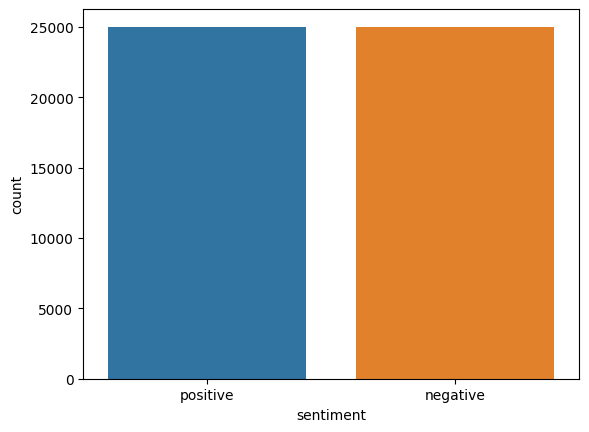

In [9]:
# View different sentiments counts
count = sns.countplot(data=df_updated, x='sentiment', order=df['sentiment'].value_counts().index)
print(df_updated.shape)
plt.show()

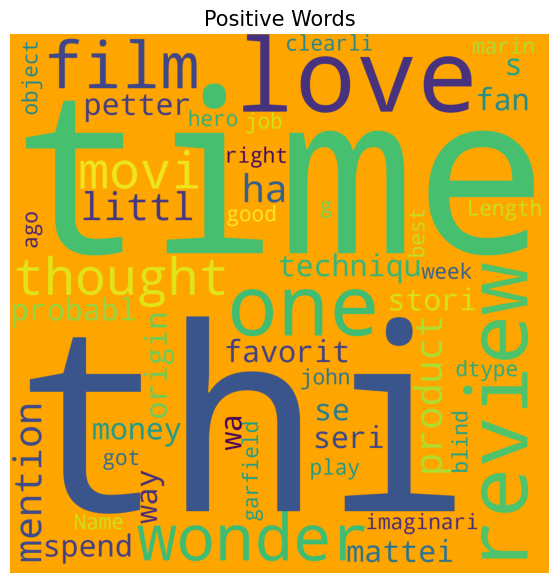

In [10]:
# Wordcloud for positive words
# This will show in graph what are the words that plays significant role for positive sentiments
positive = df_updated[df_updated['sentiment'] == 'positive']
plt.rcParams['figure.figsize'] = (7, 7)
plt.style.use('fast')
wc = WordCloud(background_color = 'orange', width = 1500, height = 1500).generate(str(positive['review']))
plt.title('Positive Words', fontsize = 15)
plt.imshow(wc)
plt.axis('off')
plt.show()

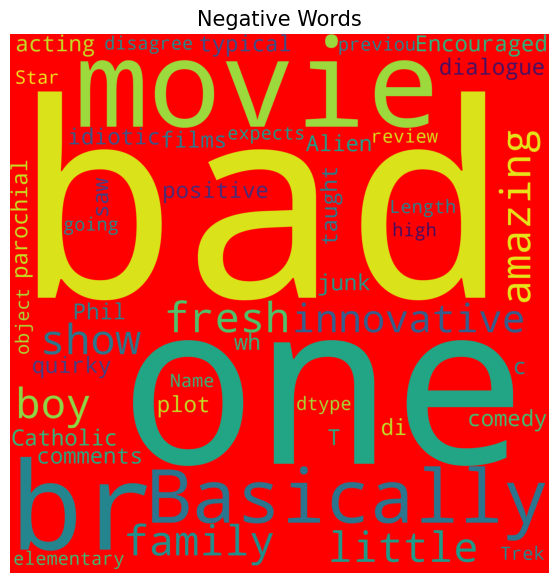

In [11]:
# Wordcloud for negative words
# This will show in graph what are the words that plays significant role for negative sentiments
negative = df[df['sentiment'] == 'negative']
plt.rcParams['figure.figsize'] = (7, 7)
plt.style.use('fast')
wc = WordCloud(background_color = 'red', width = 1500, height = 1500).generate(str(negative['review']))
plt.title('Negative Words', fontsize = 15)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [12]:
# Labelling for supervized learning
x = df_updated['review'].values
y = df_updated['sentiment'].values

In [13]:
# vectorize and remove stopwords
tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words=stopwords.words('english'))

In [14]:
# Fit and transform data for training
X = tfidf_vectorizer.fit_transform(x)

In [15]:
# Split training set and test test
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=0)

## Naive Bayes Multinominial 

In [16]:
# Training model with Multinomial Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [17]:
# Predict the test data with model
nb_model_pred = nb_model.predict(X_test)
print(nb_model_pred)

['negative' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [18]:
# List out the targeted data
nb_model_target = np.array(y_test)
print(nb_model_target)

['negative' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [19]:
# Get the accuracy of the model by comparing model prediction and target outcome
nb_accuracy_score = accuracy_score(nb_model_pred, nb_model_target)
print(nb_accuracy_score)

0.8589


In [20]:
# Classification report
print(classification_report(nb_model_target, nb_model_pred))

              precision    recall  f1-score   support

    negative       0.85      0.87      0.86      5000
    positive       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Random Forest 

In [21]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=50, criterion='entropy')

In [22]:
# Model training
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=50)

In [23]:
# Predict the test data with model
rf_model_pred = rf_model.predict(X_test)
print(rf_model_pred)

['negative' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [24]:
# List out the targeted data
rf_model_target = np.array(y_test)
print(rf_model_target)

['negative' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [25]:
# Get the accuracy of the model by comparing model prediction and target outcome
rf_accuracy_score = accuracy_score(rf_model_pred, rf_model_target)
print(rf_accuracy_score)

0.8382


In [26]:
# Classification report
print(classification_report(rf_model_target, rf_model_pred))

              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      5000
    positive       0.84      0.83      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



## Neural Network

In [27]:
# Clone dataframe again for Neural Network
df_updated_2 = df_updated.copy()
df_updated_2.head()

,review,sentiment
0,one of the other review ha mention that after ...,positive
1,a wonder littl product . the film techniqu is ...,positive
2,i thought thi wa a wonder way to spend time on...,positive
3,basic there s a famili where a littl boy jake ...,negative
4,petter mattei s love in the time of money is a...,positive


In [28]:
# Apply One hot encoding on negative and positive:
one_hot = pd.get_dummies(df["sentiment"])
if 'sentiment' in df_updated_2.columns:
    df_updated_2.drop(["sentiment"], axis=1, inplace=True)
    df_updated_2 = pd.concat([df_updated_2, one_hot], axis=1)
df_updated_2.head()

,review,negative,positive
0,one of the other review ha mention that after ...,0,1
1,a wonder littl product . the film techniqu is ...,0,1
2,i thought thi wa a wonder way to spend time on...,0,1
3,basic there s a famili where a littl boy jake ...,1,0
4,petter mattei s love in the time of money is a...,0,1


In [29]:
# Apply train test split for neural network
X_updated_2 = df_updated_2["review"].values
y_updated_2 = df_updated_2.drop("review", axis=1).values
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X_updated_2, y_updated_2, test_size=0.20, random_state=3)

In [30]:
# Apply Vectorization
vect = CountVectorizer()
X_train_vect = vect.fit_transform(X_train_updated)
X_test_vect = vect.transform(X_test_updated)

In [31]:
# Apply TFIDF
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_vect)
X_test_tfidf = tfidf.transform(X_test_vect)
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

In [32]:
# build model
checkpoint = keras.callbacks.ModelCheckpoint("model/train_{}.h5", save_best_only=True)
nn_model = Sequential()
nn_model.add(Dense(units=12673, activation="relu"))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(units=4000, activation="relu"))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(units=500, activation="relu"))
nn_model.add(Dropout(0.5))
nn_model.add(Dense(units=2, activation="softmax"))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
nn_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=2)

2022-11-27 02:50:19.265296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
# Train model
batch_size = 256
epochs = 5
nn_model.fit(
    x=X_train_tfidf,
    y=y_train_updated,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test_tfidf, y_test_updated),
    verbose=1,
    callbacks=early_stop)

Epoch 1/5
157/157 [==============================] - 26917s 172s/step - loss: 0.3028 - accuracy: 0.8654 - val_loss: 0.2641 - val_accuracy: 0.8885
Epoch 2/5
157/157 [==============================] - 1382s 9s/step - loss: 0.1152 - accuracy: 0.9577 - val_loss: 0.2892 - val_accuracy: 0.8899
Epoch 3/5
157/157 [==============================] - 1278s 8s/step - loss: 0.0355 - accuracy: 0.9886 - val_loss: 0.4891 - val_accuracy: 0.8848
Epoch 3: early stopping


In [34]:
# Save trained model
nn_model.save('trained_model')

INFO:tensorflow:Assets written to: trained_model/assets


INFO:tensorflow:Assets written to: trained_model/assets


In [35]:
# model evaluation
model_score = nn_model.evaluate(X_test_tfidf, y_test_updated, batch_size=64, verbose=1)
print("Test accuracy:", model_score[1])

157/157 [==============================] - 51s 313ms/step - loss: 0.4891 - accuracy: 0.8848
Test accuracy: 0.8848000168800354


In [36]:
# Test result
preds = nn_model.predict(X_test_tfidf)
preds

313/313 [==============================] - 77s 244ms/step


array([[1.8664220e-01, 8.1335783e-01],
       [1.9520879e-03, 9.9804795e-01],
       [9.9251115e-01, 7.4888812e-03],
       ...,
       [9.9999976e-01, 2.8908960e-07],
       [9.9999118e-01, 8.8094812e-06],
       [2.4822658e-01, 7.5177342e-01]], dtype=float32)

# Text Extraction

In [99]:
# Enter movie name to fetch the transcript from youtube.
movie_name = input("Enter the movie name to review:")

Enter the movie name to review:Captain America


In [100]:
# Create methods to extract the text from youtube transcript and normalize text before summarization and sentiment analysis

# Extract text from one youtube video
def extractTextFromYoutube(vids, vid):
    try:
        api = YouTubeTranscriptApi.get_transcript(vid)
        text = " ".join([item['text'].lower() for item in api])
        text = re.sub(r'(?<=\[).+?(?=\])', '', text).replace('[]', '')
        text = " ".join(text.split()) # Remove extra spaces
        print(f"Transcript extracted successfully for {vid}")
        return text
    except:
        print(f"{vid} doesn't have a transcript")
        vids.remove(vid)

# Extract text from 10 youtube videos and concat them to get the overall review
def createDocuments(videoIds):
    docs = []
    count = 0
    while count < 10:
        text = extractTextFromYoutube(video_ids, video_ids[count])
        if text is not None:
            count += 1
            docs.append(text)
    return docs

# lemmatize summary
def lemmatize_summary(summary):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in summary.split()])

# Prevent to get text from same video twice
def getUniqueIds(ids):
    unique_ids = []
    for id in ids:
        if id not in unique_ids:
            unique_ids.append(id)
    return unique_ids

In [101]:
# Select top 10 videos from the search result
# Extract the transcript from those 10 videos
# Add them to youtube_text_list in the form of array
movieUrl = "https://www.youtube.com/results?search_query=" + "+".join(movie_name.split())
movieReviewUrl = movieUrl + "+movie+review"
html = urllib.request.urlopen(movieReviewUrl)
ids = re.findall(r"watch\?v=(\S{11})", html.read().decode())
video_ids = getUniqueIds(ids)
print(len(video_ids), video_ids)
print()
youtube_text_list = createDocuments(video_ids)

45 ['gx9lB_uQlpg', 's8uaQDN5YeQ', 'wsv0Fv-OTIw', '7ollNhqosL8', 'DzOivKp8eOY', 'JHCgSa07a30', 'XHW-T8ULMCw', 'FH9Az4dotLo', 'o_26SGY83-I', 'rhYf6c_HPxo', 'oroMCU8SaZE', 'zKD2xuse61g', '3eBTUK1E_iM', 'QoTbGtV9Zpk', 'N8SPB0Ob1X0', '0376APsvw8U', 'emSNB6wUl44', 'I73WuA7cA44', 'NhSG87FRpUU', 'dBrKL6T0CrY', 'Q120rF6k0Vs', 'YjX9RvM04DU', 'yDfxwHKyszs', 'nIJHsLCCw0U', 'ZOfPPHcAa7E', 'JL0VR6WEqD8', 'wIXFHxBBFII', 'qA-huwesTfA', '5YcJLiQG610', 'JPgBDY1dhBU', 'dhgC3MOsX-8', 'vQNx5s0Nw-0', 'APRu1Hj9tLs', 'UJbaWZsp2CE', 'Krx0FoupoA8', 'e9BhJY-QRmg', 'rIqbJBpsJLo', '7MbbhM9cycU', 'iJNoOVk5RZg', 'K8ze_MtaCc4', 'GlKn01xTYpI', '_aE7EGY2NrY', '_LWRrz9LKmo', '2SdTl_XhfEQ', 'qJjNpsn5n40']

Transcript extracted successfully for gx9lB_uQlpg
Transcript extracted successfully for s8uaQDN5YeQ
wsv0Fv-OTIw doesn't have a transcript
Transcript extracted successfully for 7ollNhqosL8
Transcript extracted successfully for DzOivKp8eOY
Transcript extracted successfully for JHCgSa07a30
Transcript extracted successfull

In [102]:
# Join those items from youtube_text_list to create a document
youtube_text = ". ".join(doc for doc in youtube_text_list if doc != None)
print(youtube_text)

merica captain america the first avenger i'm sure this movie has a subtitle the first avenger so other parts of the world can give a and because it doesn't feature big macs bon jovi macgyver rest assured if it did feature big macs bon jovi and macgyver it was just been called captain america because that is how we roll now i think a lot was riding on captain america the first avenger because you know it's the first avenger if this movie failed the whole avengers thing that they're going for would kind of feel like it was built on bricks of so captain america is the story of steve rogers played by chris evans and i got to say he is so absurdly skinny i saw it in the trailers and i was really impressed in the trailers how we look but when you see it on screen you're like that's impossible he looks like chris evans if he had aids and they superimposed his face on like golems body he looks absurdly sickly and this is world war two and there are two kinds of people in the world americans an

# Text Summarization

In [103]:
# Summarize the document with Abstractive method through spacy
# Here are the following steps taken to summarize the text
    # Tokenize the text with the SpaCy pipeline. This segments the text into words, punctuation, and so on, using grammatical rules specific to the English language. 
    # Count the number of times a word is used (not including stop words or punctuation), then normalize the count. A word that’s used more frequently has a higher normalized count.
    # Calculate the sum of the normalized count for each sentence.
    # Extract a percentage of the highest ranked sentences. These serve as our summary.
def summarize(text, per):
    nlp = spacy.load('en_core_web_sm')
    doc= nlp(text)
    tokens=[token.text for token in doc] # Tokenize the text with the SpaCy pipeline
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1 # Count the number of times a word is used 
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()] # Calculate the sum of the normalized count for each sentence
    select_length=int(len(sentence_tokens)*per)
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get) # Extract a percentage of the highest ranked sentences
    final_summary=[word.text for word in summary]
    summary=''.join(final_summary)
    return summary

### Summary

In [104]:
# Print summarizez text
youtube_text_summary = lemmatize_summary(summarize(youtube_text, 0.005))
print(youtube_text_summary)

i'm reviewing one movie in the mcu in release order leading up to infinity or this is the sixth part and that mean we are talking about captain america the first avenger if you're new to this series it's both a review and it's a retrospective kind of an exploration of the movie place in the mcu in general but the big idea is i want to start a conversation so join me down in the comment section tell me if you love it you hate it got how you feel about it it place in the series in general i really want to start good conversation that really is what this is all about in prepping u talking through the mcu in preparation for that high point of this whole thing that it's all been leading to infinity war so join me down below and with that said let's get started talking about the background of captain america captain america wa first brought to the silver screen in a series of theatrical serial released in the 1940s later in the 70 a pair of tv movie starring captain america wa released then 

### Sentiment Analysis

In [105]:
# Label positive and negative for 1 and 0 from neural network
nn_result = ''
testing_text = vect.transform([youtube_text_summary])
testing_text = tfidf.transform(testing_text)
testing_text = testing_text.toarray()
nn_pred = nn_model.predict(testing_text)
print(nn_pred)
if np.argmax(nn_pred,axis=1)[0] == 1:
    nn_result = 'positive'
else:
    nn_result = 'negative'

1/1 [==============================] - 0s 254ms/step
[[0.01624741 0.9837526 ]]


In [106]:
# Print the result of sentiment analysis of summarized text from three models trained above. 
print("Sentiment Analysis from Random Forest is", rf_model.predict(tfidf_vectorizer.transform([youtube_text_summary]))[0])
print("Sentiment Analysis from Naive bayes is", nb_model.predict(tfidf_vectorizer.transform([youtube_text_summary]))[0])
print("Sentiment Analysis from Neural Network is", nn_result)


Sentiment Analysis from Random Forest is positive
Sentiment Analysis from Naive bayes is negative
Sentiment Analysis from Neural Network is positive
